# Volume 3: ARMA Models
    <Name>
    <Class>
    <Date>

In [1]:
from scipy.stats.distributions import norm
from scipy.optimize import fmin, minimize
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tsa.api import VARMAX
import statsmodels.api as sm
from pydataset import data as pydata
from statsmodels.tsa.stattools import arma_order_select_ic as order_select
import pandas as pd

## Helper Functions

In [2]:
def kalman(F, Q, H, time_series):
    # Get dimensions
    dim_states = F.shape[0]

    # Initialize variables
    # covs[i] = P_{i | i-1}
    covs = np.zeros((len(time_series), dim_states, dim_states))
    mus = np.zeros((len(time_series), dim_states))

    # Solve of for first mu and cov
    covs[0] = np.linalg.solve(np.eye(dim_states**2) - np.kron(F,F), 
                              np.eye(dim_states**2).dot(Q.flatten())).reshape(
                            (dim_states,dim_states))
    mus[0] = np.zeros((dim_states,))

    # Update Kalman Filter
    for i in range(1, len(time_series)):
        #FIXME
        t1 = np.linalg.solve(H.dot(covs[i-1]).dot(H.T),np.eye(H.shape[0]))
        t2 = covs[i-1].dot(H.T.dot(t1.dot(H.dot(covs[i-1]))))
        covs[i] = F.dot((covs[i-1] - t2).dot(F.T)) + Q
        mus[i] = F.dot(mus[i-1]) + F.dot(covs[i-1].dot(H.T.dot(t1))).dot(
                time_series[i-1] - H.dot(mus[i-1]))
    return mus, covs

def state_space_rep(phis, thetas, mu, sigma):
    # Initialize variables
    dim_states = max(len(phis), len(thetas)+1)
    dim_time_series = 1 #hardcoded for 1d time_series

    F = np.zeros((dim_states,dim_states))
    Q = np.zeros((dim_states, dim_states))
    H = np.zeros((dim_time_series, dim_states))

    # Create F
    F[0][:len(phis)] = phis
    F[1:,:-1] = np.eye(dim_states - 1)
    # Create Q
    Q[0][0] = sigma**2
    # Create H
    H[0][0] = 1.
    H[0][1:len(thetas)+1] = thetas

    return F, Q, H, dim_states, dim_time_series

## Problem 1

In [92]:
def arma_forecast_naive(file='weather.npy',p=2,q=1,n=20):
    """
    Perform ARMA(2,1) on data. Let error terms be drawn from
    a standard normal and let all constants be 1.
    Predict n values and plot original data with predictions.

    Parameters:
        file (str): data file
        p (int): order of autoregressive model
        q (int): order of moving average model
        n (int): number of future predictions
    """
    
    phi = 0.5
    theta = 0.1
    Z = np.diff(np.load(file))
    delz = []
    eps = np.random.normal(0,1,size = len(Z))
    
    for t in range(n):
        
        delz.append(phi * np.sum([Z[t - i] for i in range(p)]) + theta * np.sum([eps[t-j] for j in range(q)]) + eps[t])
        
    plt.figure(figsize = (12,6))
    plt.plot(range(0,len(Z)), Z, label = "Old Data")
    plt.plot(range(len(Z),len(Z)+n), delz, label = "New Data")
    plt.legend()
    plt.title("ARMA(2,1) Naive Forecast")
    plt.xlabel("Day of the Month")
    plt.ylabel("Change in Temperature (C) - $\mu$ = 0")


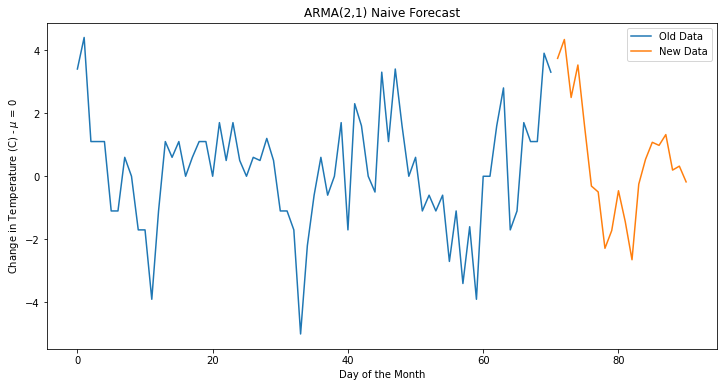

In [93]:
arma_forecast_naive()

## Problem 2

In [115]:
def arma_likelihood(filename='weather.npy', phis=np.array([0.9]), thetas=np.array([0]), mu=17., std=0.4):
    """
    Transfer the ARMA model into state space.
    Return the log-likelihood of the ARMA model.

    Parameters:
        file (str): data file
        phis (ndarray): coefficients of autoregressive model
        thetas (ndarray): coefficients of moving average model
        mu (float): mean of errorm
        std (float): standard deviation of error

    Return:
        log_likelihood (float)
    """
    z = np.diff(np.load(filename))
    F, Q, H, dim_states, dim_time_series = state_space_rep(phis, thetas, mu, std)
    X, P = kalman(F, Q, H, z - mu)
    return np.sum([np.log(norm((H@X[t] + mu)[0], np.sqrt(H@P[t]@H.T)[0,0]).pdf(z[t])) for t in range(len(z))])
    

In [116]:
arma_likelihood()

-1375.1805469978774

## Problem 3

In [126]:
def model_identification(filename='weather.npy',p_max=4,q_max=4):
    """
    Identify parameters to minimize AIC of ARMA(p,q) model

    Parameters:
        file (str): data file
        p (int): maximum order of autoregressive model
        q (int): maximum order of moving average model

    Returns:
        phis (ndarray (p,)): coefficients for AR(p)
        thetas (ndarray (q,)): coefficients for MA(q)
        mu (float): mean of error
        std (float): std of error
    """
    z = np.diff(np.load(filename))
    n = len(z)
    
    def f(x): # x contains the phis, thetas, mu, and std
        return -1*arma_likelihood(filename, phis=x[:p], thetas=x[p:p+q], mu=x[-2], std=x[-1])
    

    aic_dict = dict() # Maps aic value to sol
    for p in range(1, p_max + 1):
        for q in range(1, q_max + 1):
            
            k = p + q + 2
    
            x0 = np.zeros(k)
            x0[-2] = z.mean()
            x0[-1] = z.std()
            sol = minimize(f, x0, method = "SLSQP")
            sol = sol['x']
            
            aic = 2*k*(1 + (k+1)/(n-k)) + 2*f(sol)
            aic_dict[aic] = sol
    smallest_aic = min(aic_dict.keys())

    return aic_dict[smallest_aic]
    

In [128]:
best_model = model_identification()

<ipython-input-115-0813ce5505c5>:19: RuntimeWarning: invalid value encountered in sqrt
  return np.sum([np.log(norm((H@X[t] + mu)[0], np.sqrt(H@P[t]@H.T)[0,0]).pdf(z[t])) for t in range(len(z))])
<ipython-input-115-0813ce5505c5>:19: RuntimeWarning: divide by zero encountered in log
  return np.sum([np.log(norm((H@X[t] + mu)[0], np.sqrt(H@P[t]@H.T)[0,0]).pdf(z[t])) for t in range(len(z))])


## Problem 4

In [150]:
def arma_forecast(filename='weather.npy', phis=np.array([0]), thetas=np.array([0]), mu=0, std=0, n=30):
    """
    Forecast future observations of data.

    Parameters:
        file (str): data file
        phis (ndarray (p,)): coefficients of AR(p)
        thetas (ndarray (q,)): coefficients of MA(q)
        mu (float): mean of ARMA model
        std (float): standard deviation of ARMA model
        n (int): number of forecast observations
    """
    
    z = np.diff(np.load(filename))
    F, Q, H, dim_states, dim_time_series = state_space_rep(phis, thetas, mu, std)
    X, P = kalman(F, Q, H, z - mu)

    xs = [X[-1]]
    ps = [P[-1]]
    
    for i in range(n-1):
        xs.append(F @ xs[-1])
        ps.append(F @ ps[-1] @ F.T + Q)
        
    for i in range(len(xs)):
        xs[i] = H @ xs[i]
        ps[i] = H @ ps[i] @ H.T
        
    xs = np.array(xs)
    
    plt.figure(figsize = (10,5))
    plt.plot(z, label = "Old data")
    plt.plot(range(71, 101), xs, '--', label = "Forecast")
    plt.plot(range(71, 101), xs - 2*std, 'g')
    plt.plot(range(71, 101), xs + 2*std, 'g', label = "95% Confidence Interval")
    plt.legend()
    plt.ylabel("Change in Temperature (C) - $\mu$ = 0")

    
    

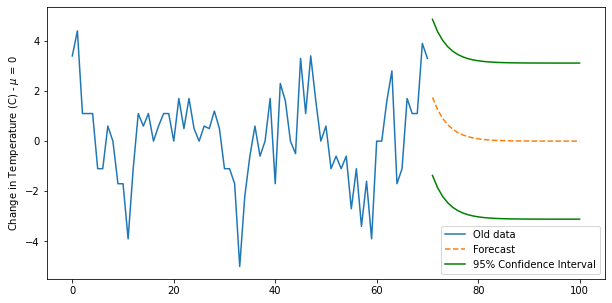

In [151]:
phis, thetas, mu, std = best_model
arma_forecast(phis = np.array([phis]), thetas = np.array([thetas]), mu = mu, std = std)


## Problem 5

In [182]:
def sm_arma(filename='weather.npy', p_max=3, q_max=3, n=30):
    """
    Build an ARMA model with statsmodel and
    predict future n values.

    Parameters:
        filename (str): data filename
        i (int): maximum order of autoregressive model
        j (int): maximum order of moving average model
        n (int): number of values to predict

    Return:
        aic (float): aic of optimal model
    """
    
    z = np.diff(np.load(filename))
    
    aic_dict = dict()
    for p in range(1, p_max + 1):
        for q in range(1, q_max + 1):
            model = ARIMA(z, order = (p, 0, q), trend = "c").fit(method = "innovations_mle")
            aic_dict[model.aic] = model
    best_model = aic_dict[min(aic_dict.keys())]

    prediction = best_model.predict(start = 0, end = len(z) + 30)
    plt.plot(z, label = "Old Data")
    plt.plot(prediction, label = "ARMA Model")
    plt.legend()
    
    

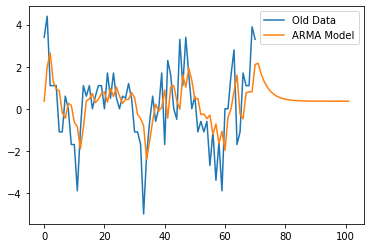

In [183]:
sm_arma()

## Problem 6

In [236]:
def sm_varma(start='1959-09-30', end='2012-09-30'):
    """
    Build an VARMAX model with statsmodel and
    predict future n values.

    Parameters:
        start (str): the data at which to begin forecasting
        end (str): the date at which to stop forecasting

    Return:
        aic (float): aic of optimal model
    """
    
    df = sm.datasets.macrodata.load_pandas().data
    dates = df[['year', 'quarter']].astype(int).astype(str)
    dates = dates["year"] + "Q" + dates["quarter"]
    dates = dates_from_str(dates)
    df.index = pd.DatetimeIndex(dates)
    df = df[['realgdp','realcons','realinv']]
    
    mod = VARMAX(df, freq = "Q-DEC")
    mod = mod.fit(maxiter=1000, disp=False, ic='aic')
    pred = mod.predict(start, end)
    
    forecast_obj = mod.get_forecast(end)
    all_CI = forecast_obj.conf_int(alpha=0.05)

    plt.figure(figsize = (15,10))
    plt.subplot(3,1,1)
    plt.plot(pred["realgdp"], label = "forecast")
    plt.plot(df["realgdp"], label = "realgdp")
    plt.plot(all_CI["lower realgdp"], '--', c = "k", label = "95% confidence interval")
    plt.plot(all_CI["upper realgdp"], '--', c = "k")
    plt.xlabel("year")
    plt.ylabel("realgpd")
    plt.legend()
    
    plt.subplot(3,1,2)
    plt.plot(pred["realcons"], label = "forecast")
    plt.plot(df["realcons"], label = "realcons")
    plt.plot(all_CI["lower realcons"], '--', c = "k", label = "95% confidence interval")
    plt.plot(all_CI["upper realcons"], '--', c = "k")
    plt.xlabel("year")
    plt.ylabel("realcons")
    plt.legend()

    
    plt.subplot(3,1,3)
    plt.plot(pred["realinv"], label = "forecast")
    plt.plot(df["realinv"], label = "realinv")
    plt.plot(all_CI["lower realinv"], '--', c = "k", label = "95% confidence interval")
    plt.plot(all_CI["upper realinv"], '--', c = "k")
    plt.xlabel("year")
    plt.ylabel("realinv")
    plt.legend()
    plt.tight_layout()
    
    
#     return pred
#     return pred
    

/Users/joshmoak/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: ic. After release 0.14, this will raise.
  warnings.warn(


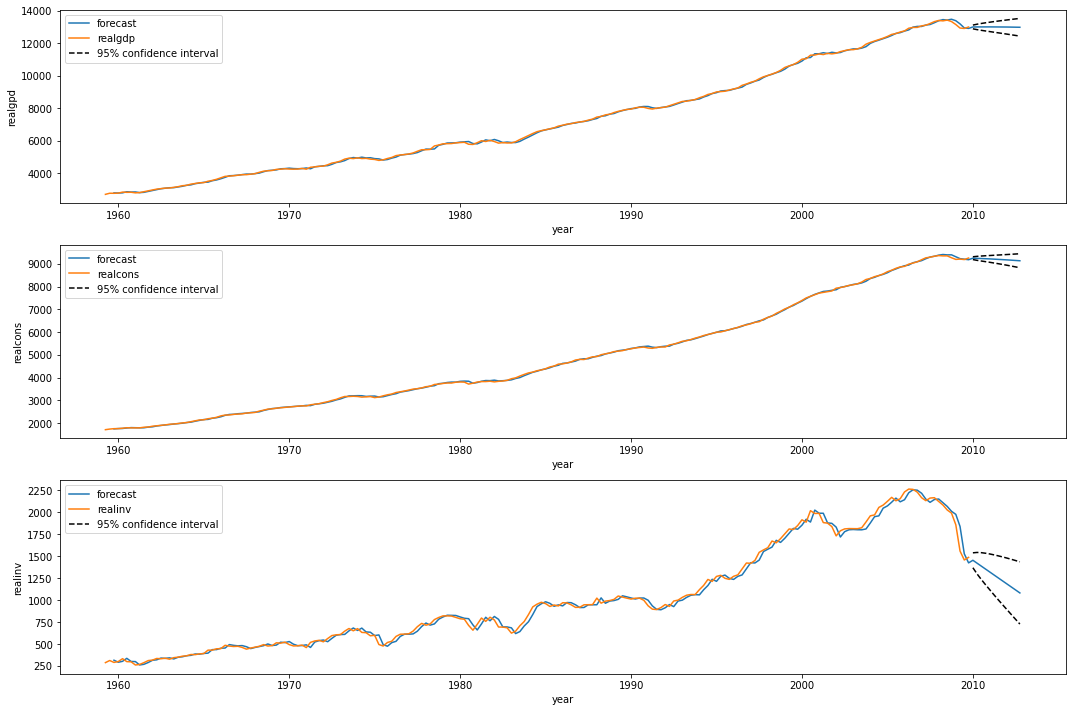

In [237]:
sm_varma()